In [1]:
import pandas as pd
import numpy as np
import os

## 데이터 설명
1. 요일 0: 토요일, 1: 일요일
2. 배우는 출연한 영화와 방송의 횟수, 수상경력을 대상3, 최우수&우수 2, 기타 1로 카운트
3. CPI(CONTENT POWER INDEX) : 콘텐츠 영향력 지수
4. 미세먼지 : 미세먼지 농도를 나타내고 미세먼지가 강하면 집에 있을 가능성이 높기에 드라마 시청 확률에 영향을 줄 수 있다.
5. 연출자 & 작가 : 이전에 했던 드라마 중 시청률 20%넘은 작품수와 수상경력을 카운트
6. 특이사항 0: 없음, 1: 있음 - 월드컵, 아시안컵, 올림픽, 추석연휴, 설날연휴 등 방송편성시간 변경

In [2]:
# Data
path = os.getcwd()
df = pd.read_csv(path+"/drama.csv")
print("\t============================\n\tDATA shape is {}\n\t============================".format(df.shape))
df.head()

	DATA shape is (784, 14)


,드라마,날짜,회차,요일,배우,CPI,CPI증감률,경제성장률,실업률,미세먼지,연출자,작가,특이사항,시청률
0,넝쿨째 굴러온 당신 (2012.02.25~2012.09.09),2012.02.25,1,0,75,96.436,2.9,0.7,4.2,47,5,10,0,22.3
1,넝쿨째 굴러온 당신 (2012.02.25~2012.09.09),2012.02.26,2,1,75,96.436,2.9,0.7,4.2,47,5,10,0,28.9
2,넝쿨째 굴러온 당신 (2012.02.25~2012.09.09),2012.03.03,3,0,75,96.436,2.9,0.7,3.7,43,5,10,0,25.7
3,넝쿨째 굴러온 당신 (2012.02.25~2012.09.09),2012.03.04,4,1,75,96.436,2.9,0.7,3.7,43,5,10,0,29.9
4,넝쿨째 굴러온 당신 (2012.02.25~2012.09.09),2012.03.10,5,0,75,96.436,2.9,0.7,3.7,43,5,10,0,26.9


### Random Forest를 위해 ['회차','요일','배우','미세먼지','연출자','작가','특이사항','시청률']만 뽑아서 사용한다.

In [220]:
data = df[['회차','요일','배우','미세먼지','연출자','작가','특이사항','시청률']]
data.head()

,회차,요일,배우,미세먼지,연출자,작가,특이사항,시청률
0,1,0,75,47,5,10,0,22.3
1,2,1,75,47,5,10,0,28.9
2,3,0,75,43,5,10,0,25.7
3,4,1,75,43,5,10,0,29.9
4,5,0,75,43,5,10,0,26.9


# 데이터 확인

In [221]:
data.rename(columns={'회차': 'Episode', '요일': 'Day', '배우': 'Actor', '미세먼지': 'Dust',
                     '연출자': 'Director', '작가': 'Author', '특이사항': 'Exception', '시청률': 'Rating'}, inplace=True)

/home/smsm8898/miniconda3/envs/tf/lib/python3.7/site-packages/pandas/core/frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 784 entries, 0 to 783
Data columns (total 8 columns):
Episode      784 non-null int64
Day          784 non-null int64
Actor        784 non-null int64
Dust         784 non-null int64
Director     784 non-null int64
Author       784 non-null int64
Exception    784 non-null int64
Rating       784 non-null float64
dtypes: float64(1), int64(7)
memory usage: 49.1 KB


In [6]:
data.describe()

,Episode,Day,Actor,Dust,Director,Author,Exception,Rating
count,784.000000,784.000000,784.000000,784.000000,784.000000,784.000000,784.000000,784.000000
mean,26.682398,0.503827,66.491071,42.697704,3.547194,7.492347,0.054847,29.372959
std,15.181655,0.500305,7.719536,13.573101,1.196127,3.350522,0.227827,5.846550
min,1.000000,0.000000,53.000000,19.000000,1.000000,2.000000,0.000000,14.900000
25%,14.000000,0.000000,61.000000,32.000000,3.000000,5.000000,0.000000,25.000000
50%,27.000000,1.000000,65.000000,42.000000,3.000000,6.000000,0.000000,28.375000
75%,40.000000,1.000000,74.000000,49.000000,5.000000,11.000000,0.000000,32.600000
max,58.000000,1.000000,79.000000,91.000000,5.000000,13.000000,1.000000,48.300000


/home/smsm8898/miniconda3/envs/tf/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/smsm8898/miniconda3/envs/tf/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/smsm8898/miniconda3/envs/tf/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/smsm8898/miniconda3/envs/tf/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


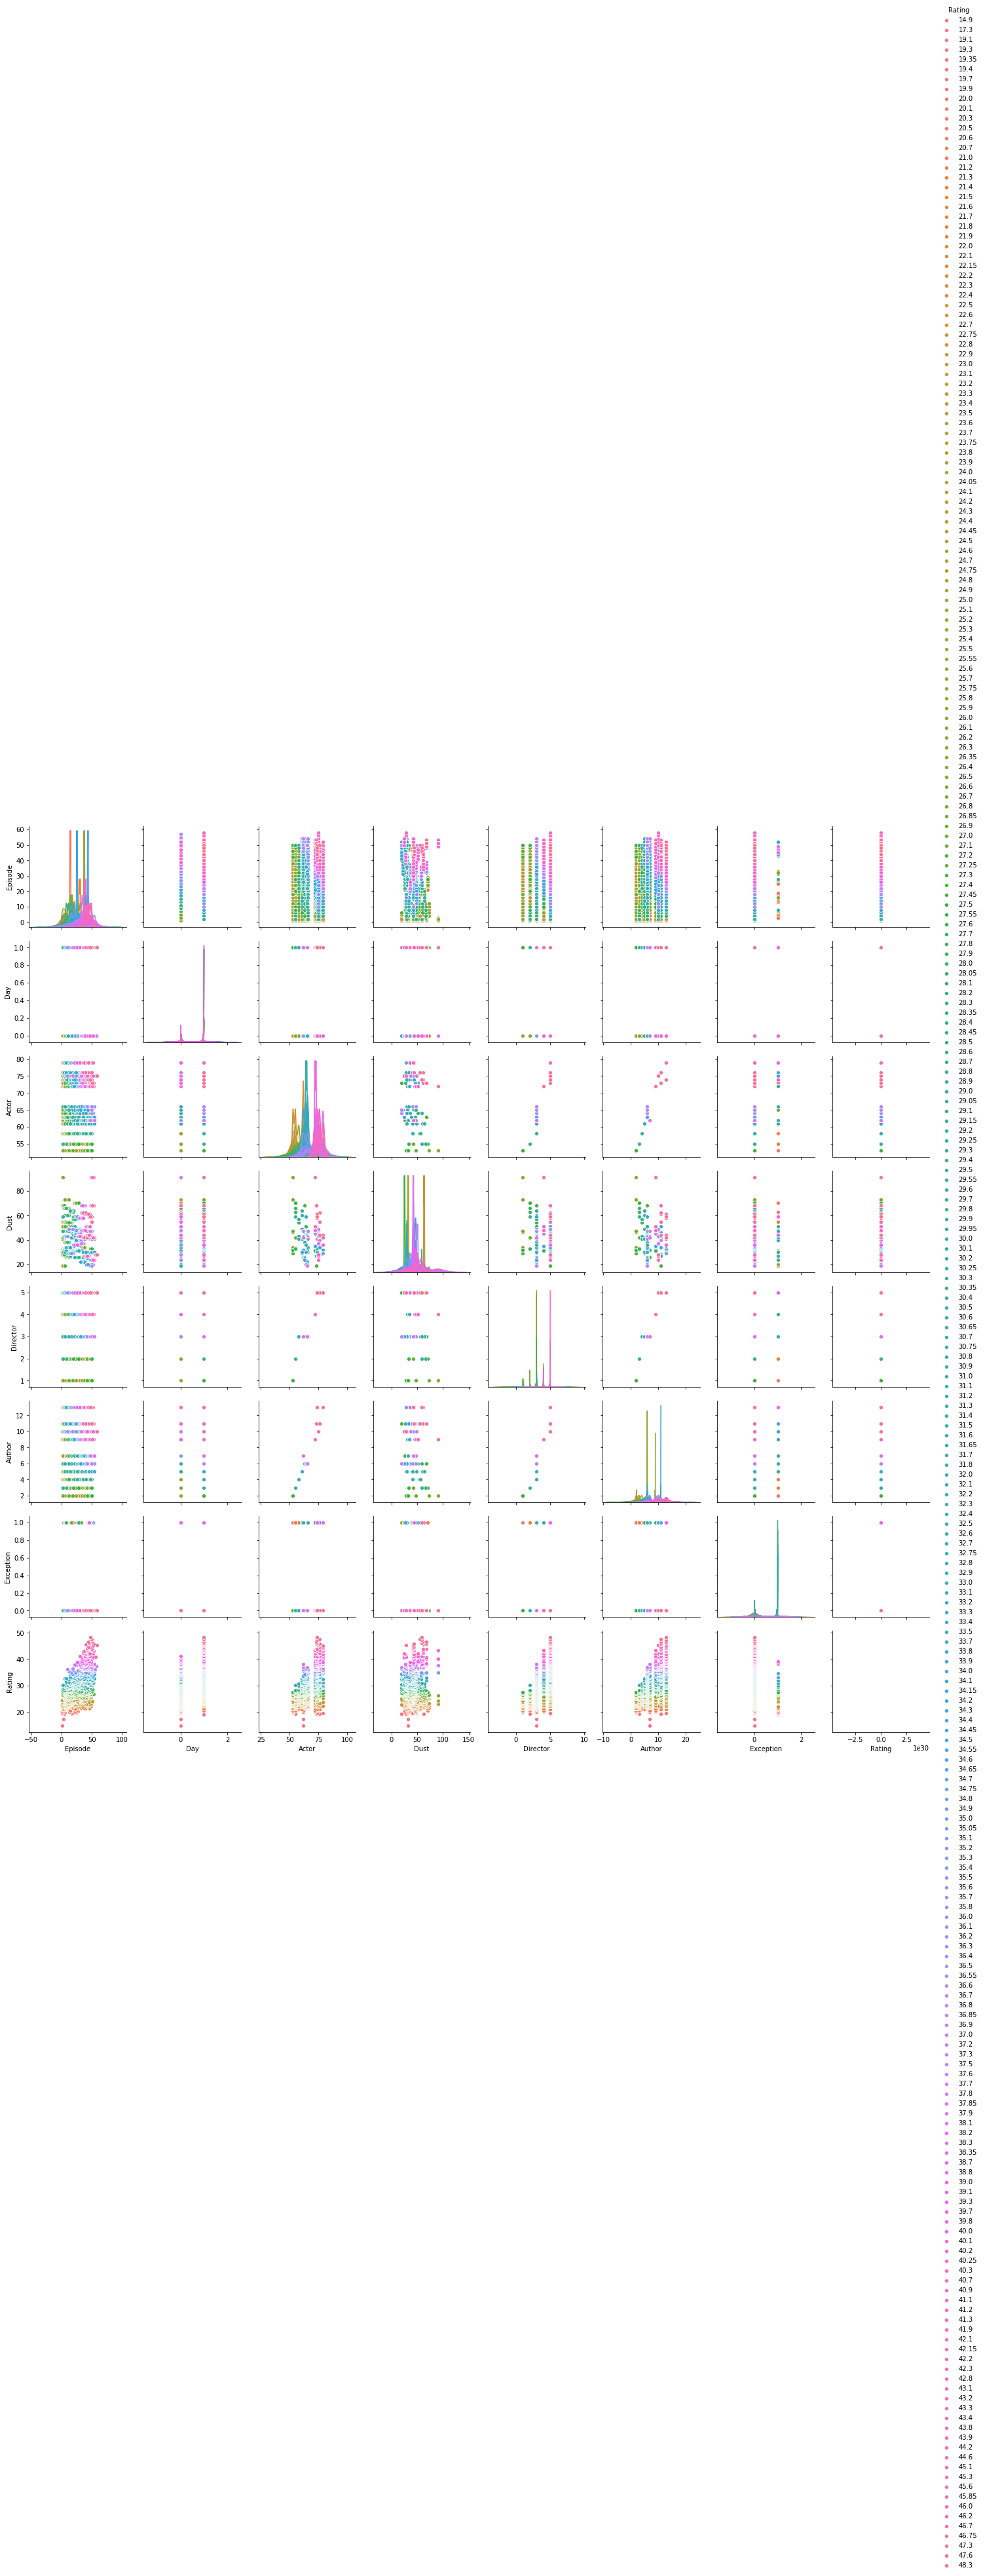

In [44]:
temp = data

sns.pairplot(temp, hue='Rating')

# 1. 목표 
### 기존의 15개의 주말 Drama 시청률을 통해 다음 Drama 시청률 예측하기

# 2. 계획
0. 15개의 드라마를 통해 supervised learning을 한다.
1. 먼저 드라마 별로 변수를 나눈다.
2. 선택된 feature를 통해 training을 한다.
3. 75%를 train으로 25%를 test로 사용한다

### 다양한 Regrssion을 이용하여 Model Training하기

In [7]:
# Normalize
data_norm = (data.iloc[:,:-1]-data.iloc[:,:-1].mean())/data.iloc[:,:-1].std()
print(data_norm.shape)
data_norm

(784, 7)


,Episode,Day,Actor,Dust,Director,Author,Exception
0,-1.691673,-1.007040,1.102259,0.316972,1.214592,0.748437,-0.24074
1,-1.625804,0.991743,1.102259,0.316972,1.214592,0.748437,-0.24074
2,-1.559935,-1.007040,1.102259,0.022272,1.214592,0.748437,-0.24074
3,-1.494066,0.991743,1.102259,0.022272,1.214592,0.748437,-0.24074
4,-1.428197,-1.007040,1.102259,0.022272,1.214592,0.748437,-0.24074
...,...,...,...,...,...,...,...
779,1.535906,0.991743,-0.452239,-1.377556,-0.457471,-0.445407,-0.24074
780,1.601775,-1.007040,-0.452239,-1.377556,-0.457471,-0.445407,-0.24074
781,1.667644,0.991743,-0.452239,-1.377556,-0.457471,-0.445407,-0.24074
782,1.733513,-1.007040,-0.452239,-1.377556,-0.457471,-0.445407,-0.24074


In [11]:
# Train & Test Split
test_size = 0.75
row_size = int(df.shape[0]*test_size)

X_train, y_train, X_test, y_test = data_norm.iloc[:row_size,:-1], data.iloc[:row_size,-1:],data_norm.iloc[row_size:,:-1],data.iloc[row_size:,-1:]
print("len of X_train is {}\nlen of y_train is {}\nlen of X_test is {}\nlen of y_test is {}\n".format(len(X_train),len(y_train),len(X_test),len(y_test)))

len of X_train is 588
len of y_train is 588
len of X_test is 196
len of y_test is 196



In [61]:
test_length = 196
data['true'] = 1
data['result']=0

/home/smsm8898/miniconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/smsm8898/miniconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [153]:
count = 0
for i in range(784):
    if data['Rating'][i]>mean:
        count+=1
        
print(count)
print(784-count)


349
435


# 다양한 model에 Data를 학습하여 비교해보기

In [161]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import statsmodels.api as sm

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score

Plus = np.loadtxt(path+"/201001-201202.txt")
len(Plus)
a = data['Rating'].sum()
mean = (a+sum(Plus))/(26+784)
mean

29.291234567901235

### 1. LinearRegression

[[88 22]
 [ 9 77]]
              precision    recall  f1-score   support

     class 0       0.78      0.90      0.83        86
     class 1       0.91      0.80      0.85       110

    accuracy                           0.84       196
   macro avg       0.84      0.85      0.84       196
weighted avg       0.85      0.84      0.84       196



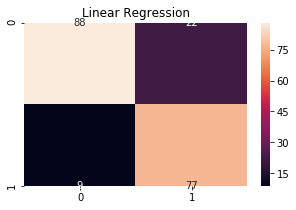

In [219]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

# 학습 진행
LR = LinearRegression()
LR.fit(X_train, y_train)

# 예측
y_pred = LR.predict(X_test)
result1 = list()
result2 = list()

for i in range(test_length):
    if y_pred[i]>mean:
        result1.append(1)
    else:
        result1.append(0)
y_pred = result1
for i in range(test_length):
    if y_test.values[i]>mean:
        result2.append(1)
    else:
        result2.append(0)        
y_true = result2

# y_true = [1 for i in range(len(result))]
cnf = metrics.confusion_matrix(y_true, y_pred,labels=[1, 0])
print(cnf)

print(classification_report(y_true, y_pred, target_names=['class 0', 'class 1']))

plt.figure(figsize = (5,3))
plt.title('Linear Regression')
sns.heatmap(cnf,annot = True)
# print(LR.coef_, LR.intercept_)

                                 OLS Regression Results                                
Dep. Variable:                 Rating   R-squared (uncentered):                   0.030
Model:                            OLS   Adj. R-squared (uncentered):              0.020
Method:                 Least Squares   F-statistic:                              3.018
Date:                Sat, 19 Oct 2019   Prob (F-statistic):                     0.00651
Time:                        17:49:14   Log-Likelihood:                         -2812.3
No. Observations:                 588   AIC:                                      5637.
Df Residuals:                     582   BIC:                                      5663.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

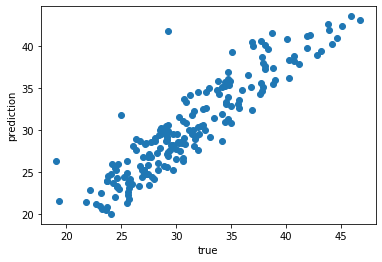

In [200]:
from statsmodels.api import OLS

model = OLS(y_train,X_train)
result = model.fit()
print(result.summary())
print(LR.coef_, LR.intercept_)
predictions = LR.predict(X_test)

plt.scatter(y_test, predictions)
plt.xlabel('true')
plt.ylabel('prediction')
plt.show()

In [205]:
data

,Episode,Day,Actor,Dust,Director,Author,Exception,Rating,true,result
0,1,0,75,47,5,10,0,22.30,1,0
1,2,1,75,47,5,10,0,28.90,1,0
2,3,0,75,43,5,10,0,25.70,1,0
3,4,1,75,43,5,10,0,29.90,1,0
4,5,0,75,43,5,10,0,26.90,1,0
...,...,...,...,...,...,...,...,...,...,...
779,50,1,63,24,3,6,0,31.65,1,0
780,51,0,63,24,3,6,0,28.50,1,0
781,52,1,63,24,3,6,0,32.70,1,0
782,53,0,63,24,3,6,0,30.80,1,0


### SVM

In [201]:
# from sklearn.svm import SVR

# # 학습 진행
# SVR = SVR(kernel = 'rbf')
# SVR.fit(X_train, y_train)

# # 예측
# y_pred = SVR.predict(X_test)
# result1 = list()
# result2 = list()

# for i in range(test_length):
#     if y_pred[i]>mean:
#         result1.append(1)
#     else:
#         result1.append(0)
# y_pred = result1
# for i in range(test_length):
#     if y_test.values[i]>mean:
#         result2.append(1)
#     else:
#         result2.append(0)        
# y_true = result2

# # y_true = [1 for i in range(len(result))]

# cnf = metrics.confusion_matrix(y_true, y_pred,labels=[1, 0])
# print(cnf)

# print(classification_report(y_true, y_pred, target_names=['class 0', 'class 1']))

# plt.figure(figsize = (7,5))
# plt.title('SVM')
# sns.heatmap(cnf,annot = True)

### RandomForest

In [202]:
# from sklearn.ensemble import RandomForestRegressor
# # 학습 진행
# RF = RandomForestRegressor(n_estimators=20, random_state=0)
# RF.fit(X_train, y_train)

# # 예측
# y_pred = RF.predict(X_test)
# result1 = list()
# result2 = list()

# for i in range(test_length):
#     if y_pred[i]>mean:
#         result1.append(1)
#     else:
#         result1.append(0)
# y_pred = result1
# for i in range(test_length):
#     if y_test.values[i]>mean:
#         result2.append(1)
#     else:
#         result2.append(0)        
# y_true = result2

# # y_true = [1 for i in range(len(result))]

# cnf = metrics.confusion_matrix(y_true, y_pred,labels=[1, 0])
# print(cnf)

# print(classification_report(y_true, y_pred, target_names=['class 0', 'class 1']))
# plt.figure(figsize = (7,5))
# plt.title('RF')
# sns.heatmap(cnf,annot = True)